In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':'1JKqY3mqBKo7q7l3GtU8mo82ceNesQIPM'}) 
downloaded.GetContentFile('Data_v2.h5')

In [ ]:
!pip install catboost

In [ ]:
!pip install xgboost

In [ ]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [ ]:
!cp /content/drive/MyDrive/f1optimization_faron.py /content

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from catboost import CatBoostClassifier, Pool
import xgboost as xgb


from f1optimization_faron import get_best_prediction

from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score , log_loss

from datetime import datetime
from tqdm import tqdm
import pickle

In [ ]:
#HDF5 format preserves data type after changing them
data = pd.HDFStore("Data_v2.h5")

In [ ]:
#accessing dataset using keys
train_data = data['train']
test_data  = data['test']

In [ ]:
def display_target_distribution(y_train, y_val):

  """
  Display target distribution in train and validation data
  """
  _, train_label_counts = np.unique(y_train, return_counts=True)
  _, val_label_counts = np.unique(y_val, return_counts=True)


  width = 0.35  # the width of the bars
  x = np.arange(2)
  fig, ax = plt.subplots(figsize=(12,6))
  rects1 = ax.bar(x - width/2, train_label_counts, width, label='Train')
  rects2 = ax.bar(x + width/2, val_label_counts, width, label='validation')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Number of datapoints')
  ax.set_title('Distribution of the Output Variable')
  ax.set_xticks(x)
  ax.set_xticklabels([0,1])
  ax.legend()
  plt.show()

def random_split(test_size = 0.1):

  """
  Split data randomly into train and validation data 
  """
  train_y = train_data['reordered'].values.tolist()
  train_x = train_data.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)

  # since there are Millions of data ,we are taking 10% of data in test set , 
  X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, stratify=train_y, test_size=0.1, random_state = 42)

  #display distribution of data
  display_target_distribution(y_train, y_val)
  return (X_train, y_train),(X_val, y_val)

def split_by_user(test_size = 0.1):
  
  #split on users
  sampled_users = train_data['user_id'].sample(n=int(0.1 * train_data['user_id'].nunique()), random_state=42,replace=False).reset_index()
  val = train_data[train_data['user_id'].isin(sampled_users['user_id'].tolist())]
  train = train_data[~train_data['user_id'].isin(sampled_users['user_id'].tolist())]

  y_train = train['reordered'].values.tolist()
  X_train = train.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)

  y_val = val['reordered'].values.tolist()
  X_val = val.drop(['user_id', 'product_id', 'order_id', 'reordered'], axis = 1)

  display_target_distribution(y_train, y_val)
  return (X_train, y_train),(X_val, y_val)


In [ ]:
def model_stats(predict_y,y_val):# Plot confusion Matrix

  """
  Display model statistics such as accuracy , precision score and confusion matrix
  """

  #predicted_y =np.array(predict_y>0.5,dtype=int).reshape(-1,).tolist()
  cm = confusion_matrix(y_val, predict_y)
  sns.heatmap(cm, cmap='Blues', annot = True, fmt="g", annot_kws={"size": 12})
  plt.show()
  print("Accuracy :",accuracy_score(y_val, predict_y))
  print("Precision :",precision_score(y_val, predict_y))

In [ ]:
def convert_to_string(row):
    """
    convert series value to ist of strings
    """
    list_string = list(map(str, row.tolist())) # convert series > list > list of strings
    return " ".join(list_string)

def globl_threshold_products(model = None, scaler = None, model_type = 'xgb', val_file="Data_v2.h5"):

    """
    Get all products above threshold and join them
    """

    #loading test data
    test_data = pd.HDFStore(val_file)
    test_data = test_data['test']
    data = test_data.drop(['user_id', 'product_id', 'order_id'], axis = 1)

    #scale test data
    if scaler != None:
        data = scaler.transform(data)

    #if model is xgb use model.predict(), else use model.predict_proba()
    if model_type == 'xgb':
      dtest = xgb.DMatrix(data)
      ypred = model.predict(dtest)
    
    elif model_type == 'mlp':
      ypred = model.predict(data)
      ypred = ypred.reshape(-1,).tolist()

    else:
      ypred = model.predict_proba(data)
      #get probabilities of class 1
      ypred = ypred[:,-1]

    #add output probablities to a column
    test_data['reordered'] =  ypred

    #create a dataframe wiith unique order id
    df = pd.DataFrame({'order_id':test_data['order_id'].unique()})

    # 3 best threshold values based on multiple runs
    for i, thresh in enumerate([0.18,0.19,0.20]):

      #get all products above threshold and join them 
      test_data_copy = test_data[test_data['reordered']>=thresh].groupby(['order_id'])['product_id'].apply(convert_to_string).reset_index(name = "products")
      
      #create a submission by merging the order_id with test_data_copy
      submission = pd.merge(test_data_copy,df, on = 'order_id', how = 'right')
      submission['order_id'] = submission['order_id'].apply(int)

      # replace empty cells with None , where no product is above threshold probability
      submission = submission.where(pd.notnull(submission), None)

      #save submission file
      submission.to_csv("submission_sample_v8_{}_{}.csv".format(i+1,model_type), index= False)
      print("Generated submission_sample_v8_{}_{}.csv successfully".format(i+1,model_type))

In [ ]:
def getscores_on_testdata(model = None ,scaler = None, model_type = 'xgb', val_file = "Data_v2.h5"):
    """
    Returns product list for every order-ID which maximizes F1-score
    
    Parameters
    ----------
    model      : The default is None.
                 Trained model is passed here  
    model_type : The default is xgb
                 Identifier to deal with both sgb and catboost models
    val_file   : The default is Data_v2.h5
                 Path of dataset is passed
    Returns
    -------
    test_products : Dataframe object
                  This dataframe contains orderID, productID's(string)

    """

    #loading test data
    test_data = pd.HDFStore(val_file)
    test_data = test_data['test']
    data = test_data.drop(['user_id', 'product_id', 'order_id'], axis = 1)

    #scale test data
    if scaler != None:
        data = scaler.transform(data)

    #if model is xgb use model.predict(), else use model.predict_proba()
    if model_type == 'xgb':
      dtest = xgb.DMatrix(data)
      ypred = model.predict(dtest)
    
    elif model_type == 'mlp':
      ypred = model.predict(data)
      ypred = ypred.reshape(-1,).tolist()
    
    else:
      ypred = model.predict_proba(data)
      #get probabilities of class 1
      ypred = ypred[:,-1]

    #add output probablities to a column
    test_data['reordered'] =  ypred
    
    #create a dataframe with orderID and list of all possible productID's
    test_products = test_data.groupby(['order_id'])['product_id'].apply(list).reset_index()
    
    #collect all probs in a single list for each OrderID
    probs = test_data.groupby(['order_id'])['reordered'].apply(list).reset_index()
    test_products['probs'] = probs['reordered']

    #run faron's optimization code to get most probable set of products which might be reordered
    products = []
    for i in tqdm(test_products.index):
        prods = get_best_prediction(test_products.iloc[i]['product_id'], test_products.iloc[i]['probs'], None)
        products.append(prods)

    test_products['products']= products
    
    test_products['order_id'] = test_products['order_id'].apply(int)
    test_products.drop(['product_id','probs'], axis = 1, inplace = True)
   
    return test_products

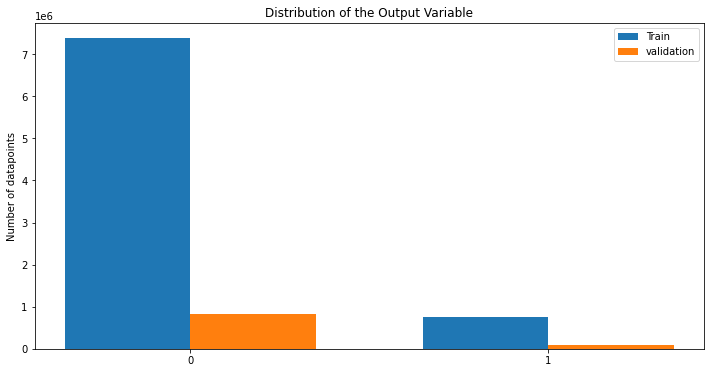

In [ ]:
#data split randomly

(X_train, y_train),(X_val, y_val) = random_split(test_size = 0.1)

## **Logistic Regression**

In [ ]:
#feature scaling for logistic regression

from sklearn.preprocessing import StandardScaler

# fit scaler on training data
scaler = StandardScaler().fit(X_train)

# transforming the data
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)

In [ ]:
#saving standard scalar
from sklearn.externals import joblib 
joblib.dump(scaler, 'standrdscaler.pkl') 

In [ ]:
log_reg = LogisticRegression(random_state=0, n_jobs = -1)
log_reg.fit(X_train_norm,y_train)

predict_y = log_reg.predict_proba(X_val_norm)
print("logloss on validation data :",log_loss(y_val, predict_y, labels=[0,1], eps=1e-15))
model_stats(np.argmax(predict_y,1),y_val)

## **Essemble:Catboost**

In [ ]:
def train_catboost(X_train, X_test, y_train, y_test, plot_importance = True, save = True, file_name = None):
    
    """
    Returns trained catboost model and output probabilities of validation set
    
    Parameters
    ----------
    X_train              : X_train data is passed 
    X_test               : X_test data is passed
    y_train              : y_train data is passed
    y_test               : y_test data is passed
    plot_importance      : The default is True
                          Boolean variable , Set to True if feature Importance
                          needs to be plotted
    save                 : The default is True
                          Boolean variable , Set to True if trained model 
                          needs to be saved
    file_name            : The default is None
                          Filename to be used while saving model
    Returns
    -------
    xgb_model            :  Trained XGBoost Model
    predict_y            : output probabilities for validation data
    """


    start_time = datetime.now()
    print("Training Started :")

    #defining set of parameters, these are optimal parameters obatined after 
    # rigorous hyperparameter Tuning
    c_model = CatBoostClassifier(task_type = "GPU",verbose=True,depth = 13, iterations= 2000,learning_rate= 0.02,scale_pos_weight= 1.0)
    c_model.fit(X_train,y_train)
    print("Training Completed ")
    end_time = datetime.now()
    difference = end_time - start_time
    time = divmod(difference.total_seconds() , 3600)
    print("Total Time : {} hours {} seconds".format(time[0], time[1]))
    
    #get output probabilities
    predict_y = c_model.predict_proba(X_test)
    print("The Test log loss is:",log_loss(y_test, predict_y, labels=[0,1], eps=1e-15))
    
    #get probs for class 1
    predict_y = predict_y[:,-1]
    
    #save the model
    if save:
        # save
        pickle.dump(c_model, open(file_name, "wb"))
    
    #plot feature importance
    if plot_importance:
        #ref: https://stackoverflow.com/a/65842279/11533069
        f_imp=pd.DataFrame({'features':train_x.columns.to_numpy(),'feature_importance': c_model.get_feature_importance()})
        f_imp.sort_values(by = 'feature_importance', ascending = False, inplace = True)

        print("Feature Importance")
        fig, ax = plt.subplots(1,1,figsize=(10,10))
        sns.barplot(x=f_imp['feature_importance'], y=f_imp['features'])
        plt.title('Feature Importance')
        plt.xlabel('Importance')
        plt.ylabel('Features')

    return c_model, predict_y

In [ ]:
c_model, predict_y = train_catboost(X_train, X_val, y_train, y_val, plot_importance = True, save = True, file_name = 'catboost_v3.pkl' )


Training Started :
0:	learn: 0.5937223	total: 362ms	remaining: 12m 3s
1:	learn: 0.5123908	total: 841ms	remaining: 14m
2:	learn: 0.4354505	total: 1.13s	remaining: 12m 33s
3:	learn: 0.3738820	total: 1.55s	remaining: 12m 52s
4:	learn: 0.3179786	total: 1.91s	remaining: 12m 42s
5:	learn: 0.2699800	total: 2.24s	remaining: 12m 25s
6:	learn: 0.2302072	total: 2.73s	remaining: 12m 56s
7:	learn: 0.1938546	total: 3.06s	remaining: 12m 42s
8:	learn: 0.1634073	total: 3.38s	remaining: 12m 26s
9:	learn: 0.1390956	total: 3.8s	remaining: 12m 36s
10:	learn: 0.1194178	total: 4.31s	remaining: 12m 59s
11:	learn: 0.1009594	total: 4.63s	remaining: 12m 46s
12:	learn: 0.0858333	total: 5s	remaining: 12m 44s
13:	learn: 0.0731829	total: 5.42s	remaining: 12m 48s
14:	learn: 0.0624119	total: 5.83s	remaining: 12m 51s
15:	learn: 0.0530300	total: 6.18s	remaining: 12m 46s
16:	learn: 0.0451406	total: 6.53s	remaining: 12m 41s
17:	learn: 0.0390160	total: 6.99s	remaining: 12m 50s
18:	learn: 0.0335412	total: 7.45s	remaining: 1

In [ ]:
#plot confusion matrix
predicted_y =np.array(predict_y>0.5,dtype=int)
cm = confusion_matrix(y_val, predicted_y)
sns.heatmap(cm, cmap='Blues', annot = True,  fmt="g", annot_kws={"size": 16})
plt.show()
print("Accuracy :",accuracy_score(y_val, predicted_y))
print("Precision :",precision_score(y_val, predicted_y))

In [ ]:
#generate submission files based on global threshold
globl_threshold_products(model = pickle.load(open("catboost_v3.pkl", "rb")), model_type = 'catboost')